In [1]:
mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats
sig_trig = 28.23                                                       #trigger cross section

In [2]:
import sys

sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')

import pythia8

In [3]:
N_events = int(1e7) 
ids = [-211, 211, -321, 321]

In [4]:
import os
from tqdm import tqdm

In [5]:
def gen_data(exp_name, conf_file, tune_pp=14, n_events=int(1e6), additional_instructions={}):

    try:
    
        os.mkdir(f'gen_data/{exp_name}')
    
    except FileExistsError: pass

    pythia = pythia8.Pythia("", False)

    files = dict(zip(ids, [open(f'gen_data/{exp_name}/{id}.csv', 'w') for id in ids]))

    for id in ids: files[id].write('pT,xF,E\n')

    pythia.readFile(conf_file)
    pythia.readString(f'Tune:pp = {tune_pp}')
        
    for inst, val in  additional_instructions.items():
            
        pythia.readString(f'{inst} = {val}')

    boost = pythia8.Vec4()
    boost.pz(mp * ((1 + (pz / mp) ** 2) ** 0.5 - 1) ** 0.5)
    boost.e((boost.pz() ** 2 + mp ** 2) ** 0.5)

    pythia.init()

    for _ in tqdm(range(n_events)):

        if not pythia.next(): continue
        
        entries = pythia.event.size()

        for j in range(entries):

            particle = pythia.event[j]

            id = particle.id()
            
            if abs(int(id)) == 211 or abs(int(id)) == 321:

                P_mu = particle.p()

                P_mu.bstback(boost)

                pT = P_mu.pT()
                xF = 2 * P_mu.pz() / root_s
                E = P_mu.e()

                files[id].write(f'{pT},{xF},{E}\n')

    sig_total = pythia.getSigmaTotal()

    sigma_file = open(f'gen_data/{exp_name}/sigma_total.txt', 'w')
    sigma_file.write(f'{sig_total}')
    sigma_file.close()

    for id in ids: files[id].close()

In [6]:
switches = {
    'Tune:pp': '1',
    'SigmaDiffractive:dampen': 'off',
    'SoftQCD:all': 'on',
    'SpaceShower:phiIntAsym': 'off',
    'SpaceShower:phiPolAsym': 'off',
    'SpaceShower:rapidityOrder': 'off',
    'SpaceShower:rapidityOrderMPI': 'off',
    'SpaceShower:samePTasMPI': 'on',
    'TimeShower:dampenBeamRecoil': 'off',
    'TimeShower:phiPolAsym': 'off'
}

In [7]:
for switch, val in switches.items():

    if val == 'off': new_val = 'on'
    elif val == 'on': new_val = 'off'
    else: new_val = val

    gen_data(exp_name=switch,
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=1,
         additional_instructions={switch: new_val},
         n_events=N_events)

100%|██████████| 10000000/10000000 [20:44<00:00, 8035.46it/s] 


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
sig_totals = {}

for switch in switches.keys():

    sigma_file = open(f'gen_data/{switch}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    sig_totals[switch] = sig_total

In [10]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [11]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [12]:
def xsect_calc(data, sig_total):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * (data['xF'] < xF + dxF / 2) * (data['pT'] > pT - dpT / 2) * (data['pT'] < pT + dpT / 2)

        dn = data[mask_for_bin]['E'].size

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append((E * (sig_total / N_events) * (dn / dp3) / norm).mean())
        err.append((E * (sig_total / N_events) * (dn / dp3) / norm).std())

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, err)

    return xsect, err

In [13]:
def calc_metric(func, xsect, err, ref):

    res = []

    for num, bin in enumerate(bins):

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if sum(mask) != 0:

            res.append(func(y_hat=xsect[num], y=ref['xsect'][mask].values[0],
                            y_hat_err=err[num], y_err=ref['error'][mask].values[0]))

    return np.where(np.isnan(res), 0, res)

In [14]:
def chi_square(y_hat, y, y_hat_err=None, y_err=None):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

In [15]:
metrics = {}

for switch in switches.keys():

    metrics[switch] = []

    sigma_file = open(f'gen_data/{switch}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    for id in ids:

        data = pd.read_csv(f'gen_data/{switch}/{id}.csv')
        ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

        xsect, err = xsect_calc(data, sig_total)

        res = calc_metric(chi_square, xsect, err, ref)

        metrics[switch].append(np.mean(res))

/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)


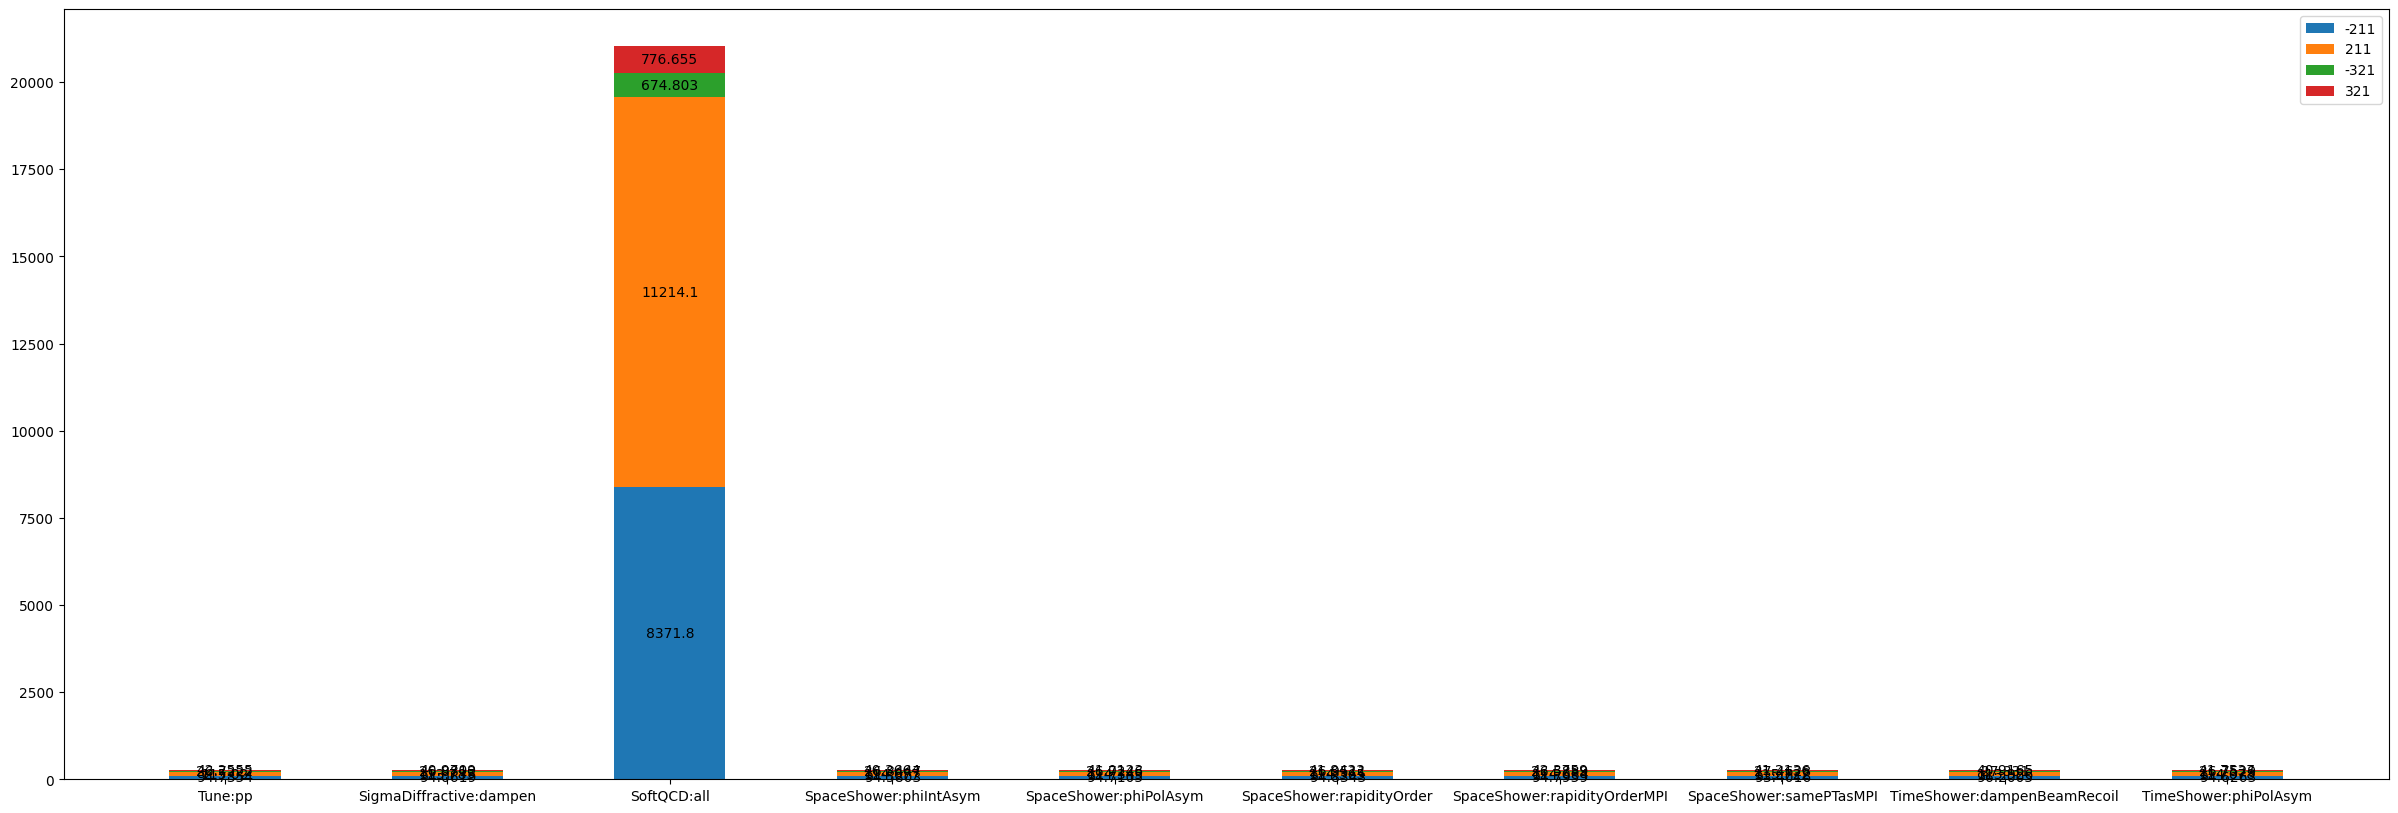

In [16]:
width = 0.5

plt.figure(figsize=(30, 10))

bottom = np.zeros(len(switches))

for num, id in enumerate(ids):

    res = np.array(list(metrics.values()))[:, num]

    p = plt.bar(switches.keys(), res, width, label=id, bottom=bottom)
    bottom += res

    plt.bar_label(p, label_type='center')

plt.legend()

plt.show()

The `SoftQCD:all` switch is the most important and without it turned on PYTHIA just doesn't work

In [17]:
metrics_without_qcd = metrics.copy()
metrics_without_qcd.pop('SoftQCD:all');

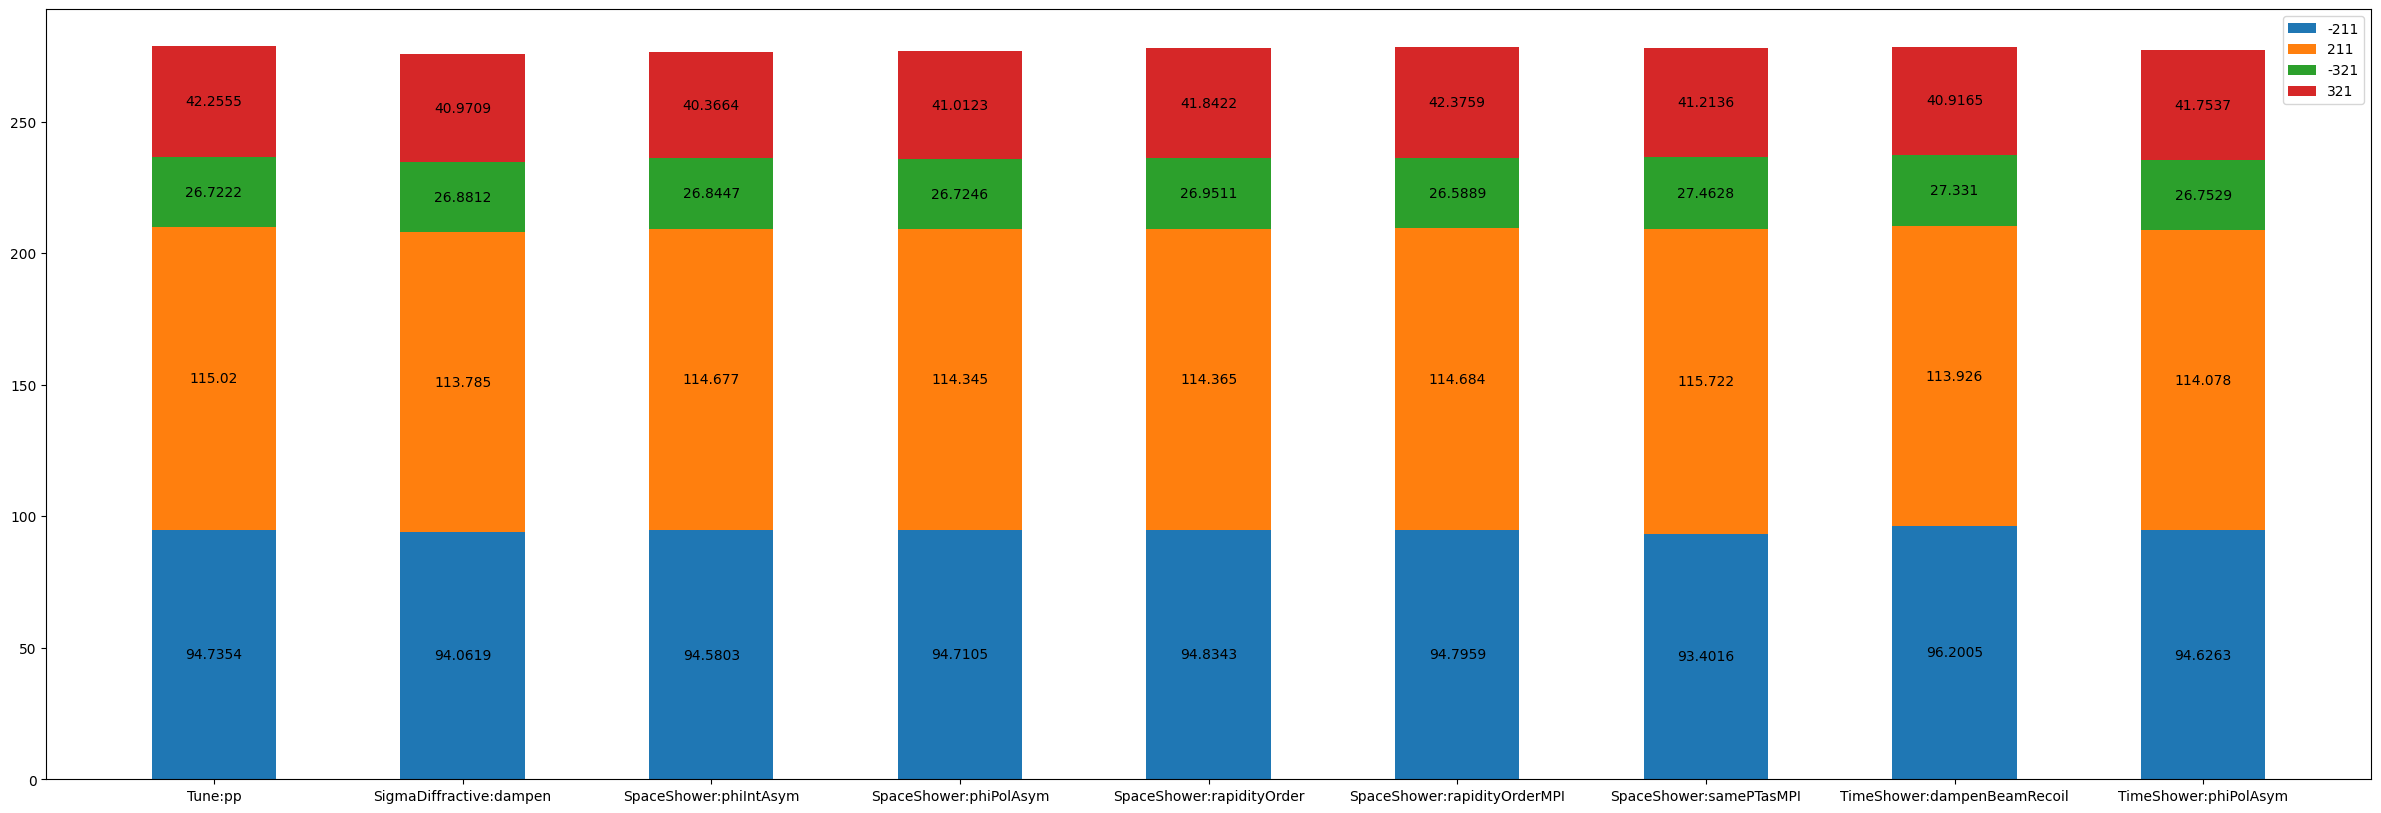

In [18]:
width = 0.5

plt.figure(figsize=(30, 10))

bottom = np.zeros(len(metrics_without_qcd))

for num, id in enumerate(ids):

    res = np.array(list(metrics_without_qcd.values()))[:, num]

    p = plt.bar(metrics_without_qcd.keys(), res, width, label=id, bottom=bottom)
    bottom += res

    plt.bar_label(p, label_type='center')

plt.legend()

plt.show()

The differences from baseline are about one or two percent

In [29]:
np.array(list(metrics_without_qcd.values()))[:,0]

array([94.73540198, 94.06185191, 94.58032807, 94.71053854, 94.83434907,
       94.79587075, 93.40156921, 96.20054179, 94.62632432, 93.24238835])

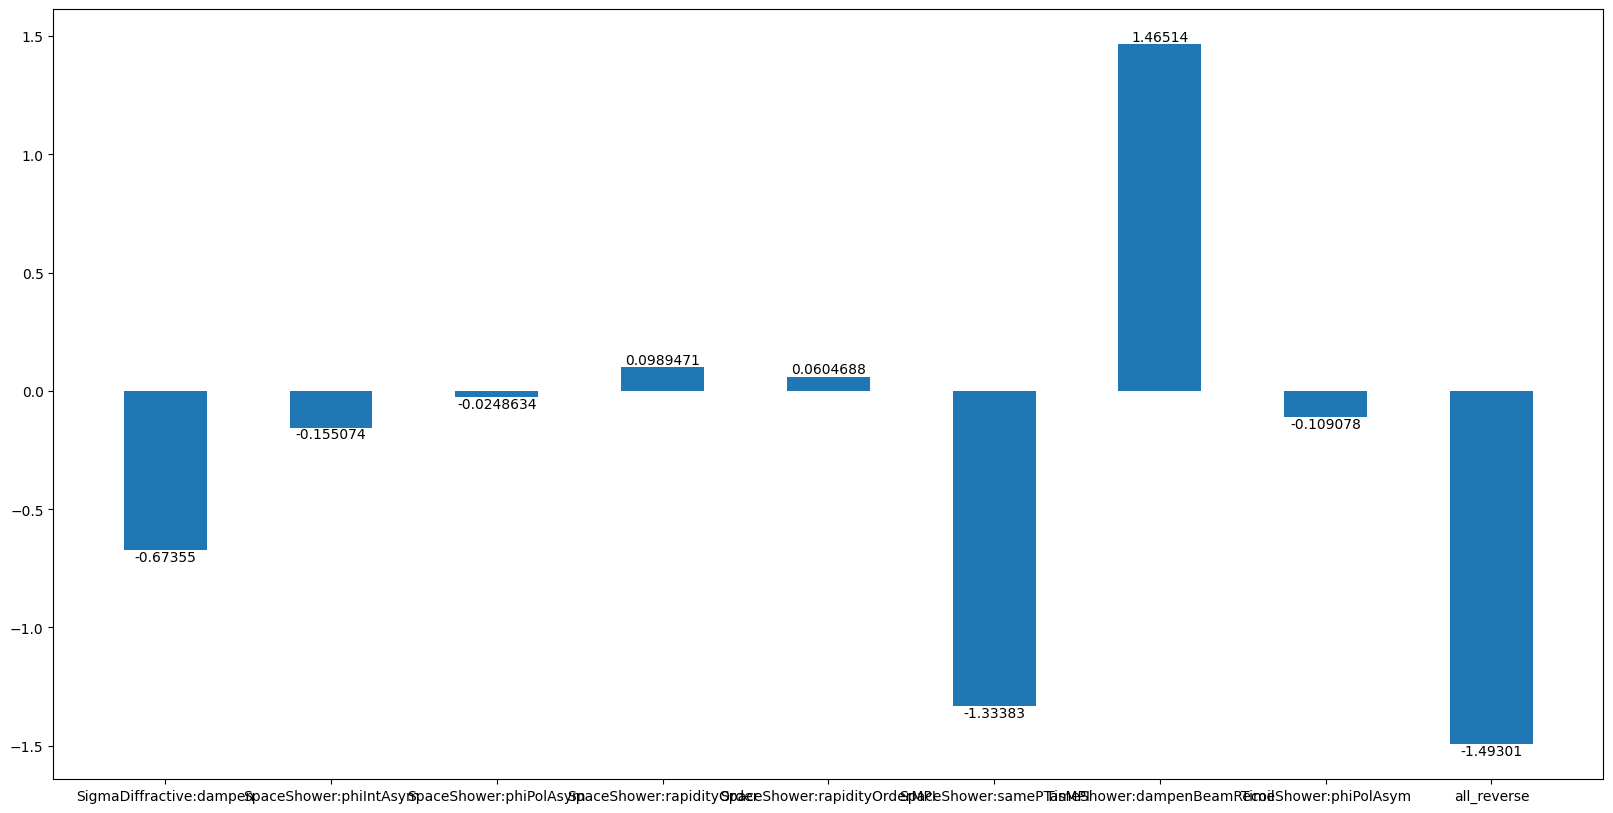

In [42]:
width = 0.5

plt.figure(figsize=(20, 10))

res = np.array(list(metrics_without_qcd.values()))[:,0]#.sum(axis=1)
res = res[1:] - res[0]

p = plt.bar(list(metrics_without_qcd.keys())[1:], res, width)

plt.bar_label(p, label_type='edge')

plt.show()

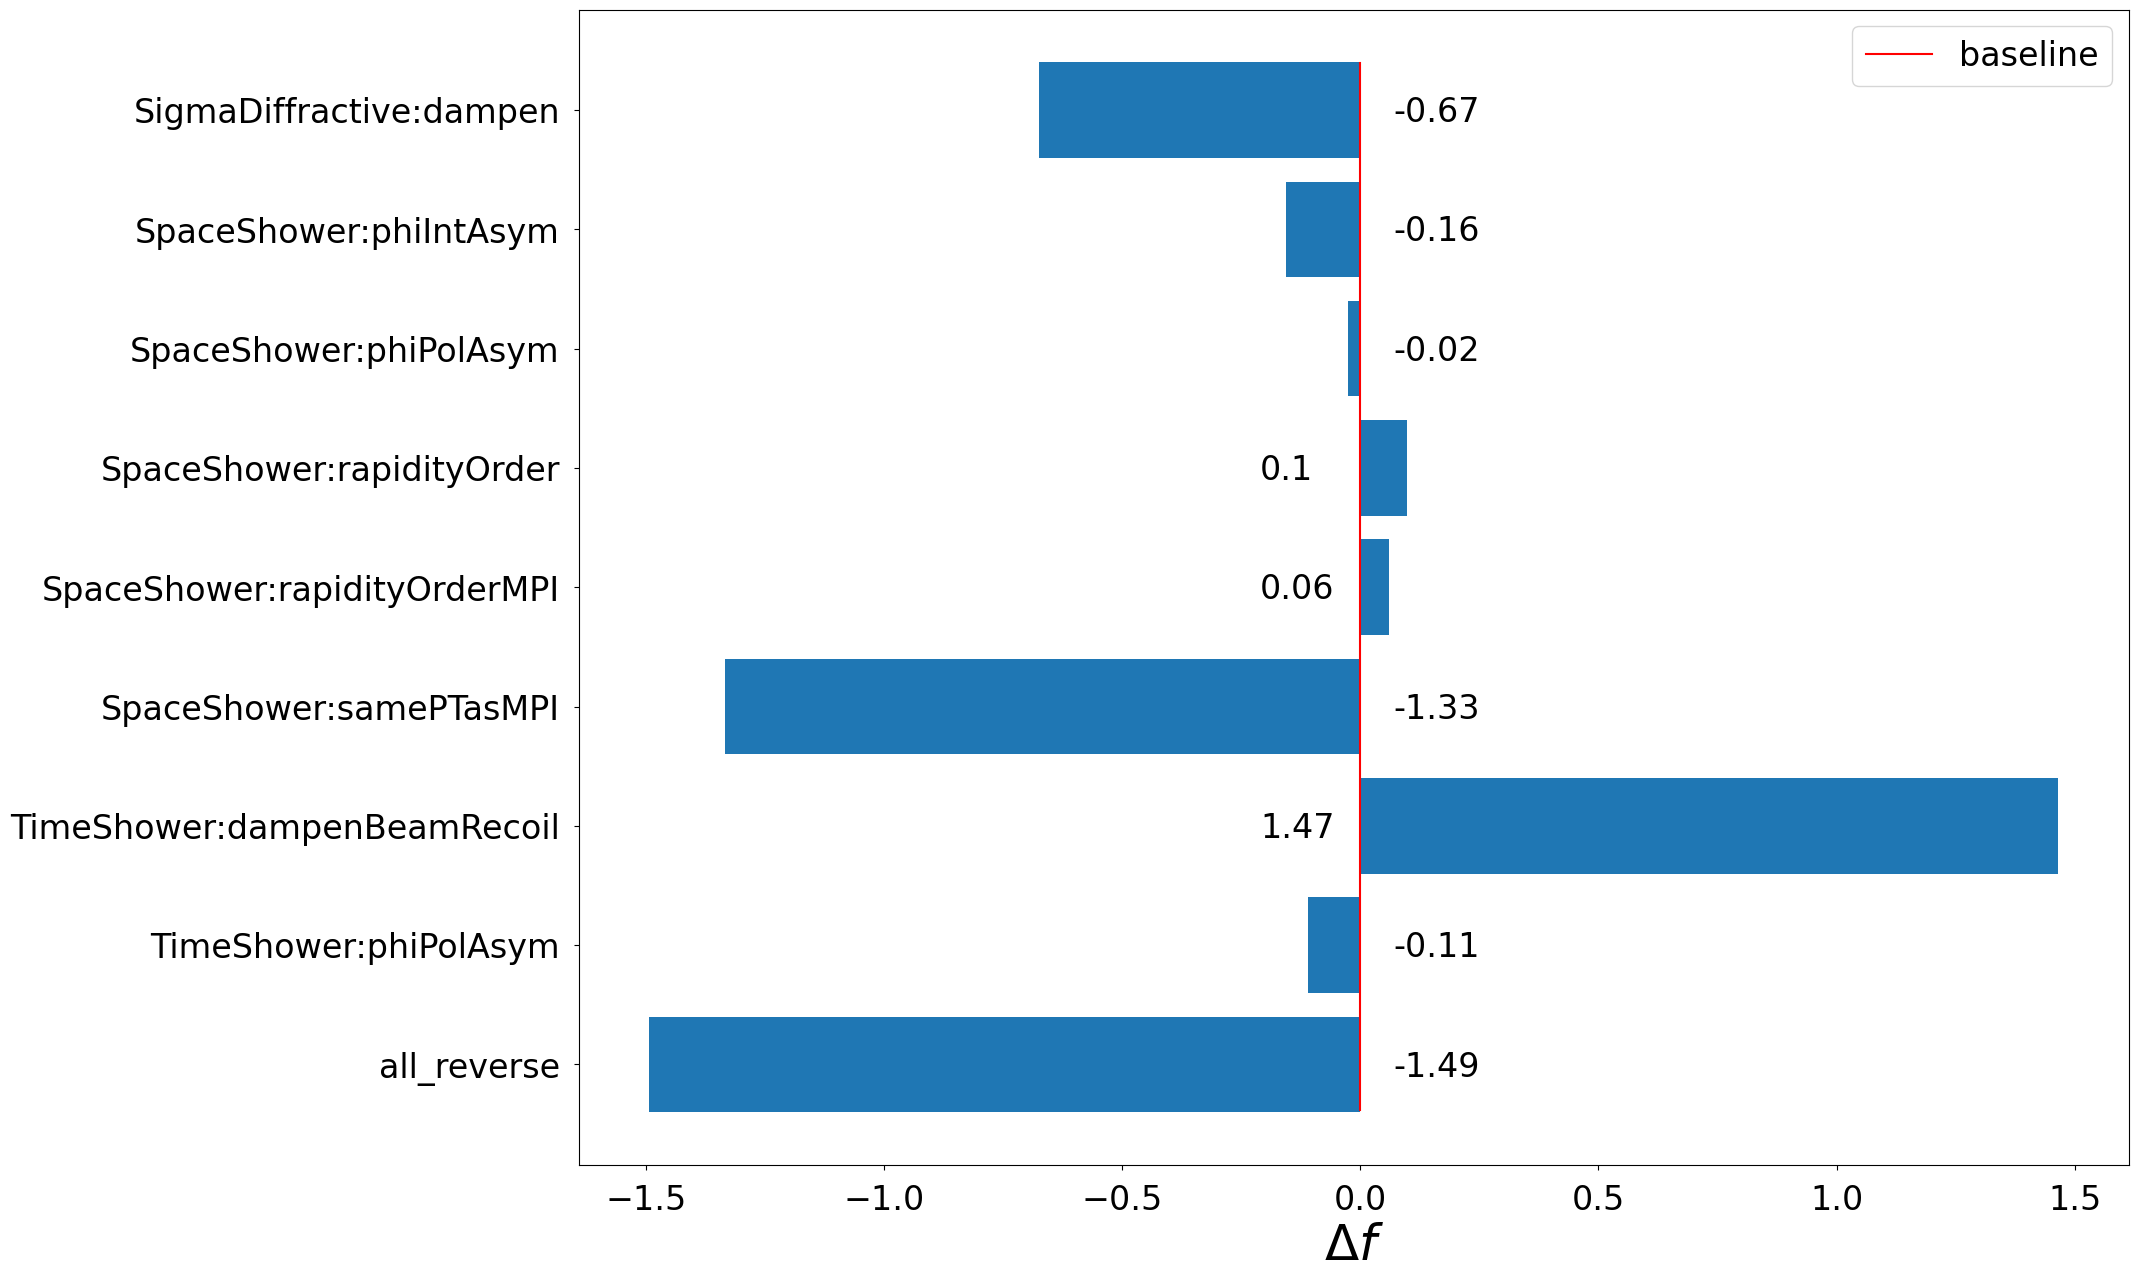

In [97]:
plt.rcParams.update({'font.size': 24})
plt.rcParams['image.cmap'] = 'plasma'
fig, ax = plt.subplots(figsize =(20, 15))
 
# Horizontal Bar Plot
ax.barh(list(metrics_without_qcd.keys())[1:], res)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
#ax.xaxis.set_ticks_position('none')
#ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 10)
 
# Show top values 
ax.invert_yaxis()
 
# Add annotation to bars
for num, i in enumerate(ax.patches):
    plt.text(-0.07 * np.sign(res[num]) - 0.14 * (res[num] >= 0), 
             i.get_y() + 0.5, 
             str(round(res[num], 2)))

ax.set_xlabel('$\Delta f$', fontdict={'size': 36})

ax.plot([0, 0], [-0.39, 8.38], color='red', label='baseline')

ax.legend()

# Show Plot
plt.show()

In [20]:
switches_reverse = {}

for switch, val in switches.items():

    if val == 'on': switches_reverse[switch] = 'off'
    elif val == 'off': switches_reverse[switch] = 'on'

switches_reverse.pop('SoftQCD:all');

In [21]:
gen_data(exp_name='all_reverse',
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=1,
         additional_instructions=switches_reverse,
         n_events=N_events)

100%|██████████| 10000000/10000000 [20:27<00:00, 8148.29it/s] 


In [22]:
metrics_without_qcd['all_reverse'] = []

sigma_file = open('gen_data/all_reverse/sigma_total.txt', 'r')
sig_total = float(sigma_file.readline())
sigma_file.close()

for id in ids:

    data = pd.read_csv(f'gen_data/all_reverse/{id}.csv')
    ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

    xsect, err = xsect_calc(data, sig_total)

    res = calc_metric(chi_square, xsect, err, ref)

    metrics_without_qcd['all_reverse'].append(np.mean(res))

/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_24514/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)


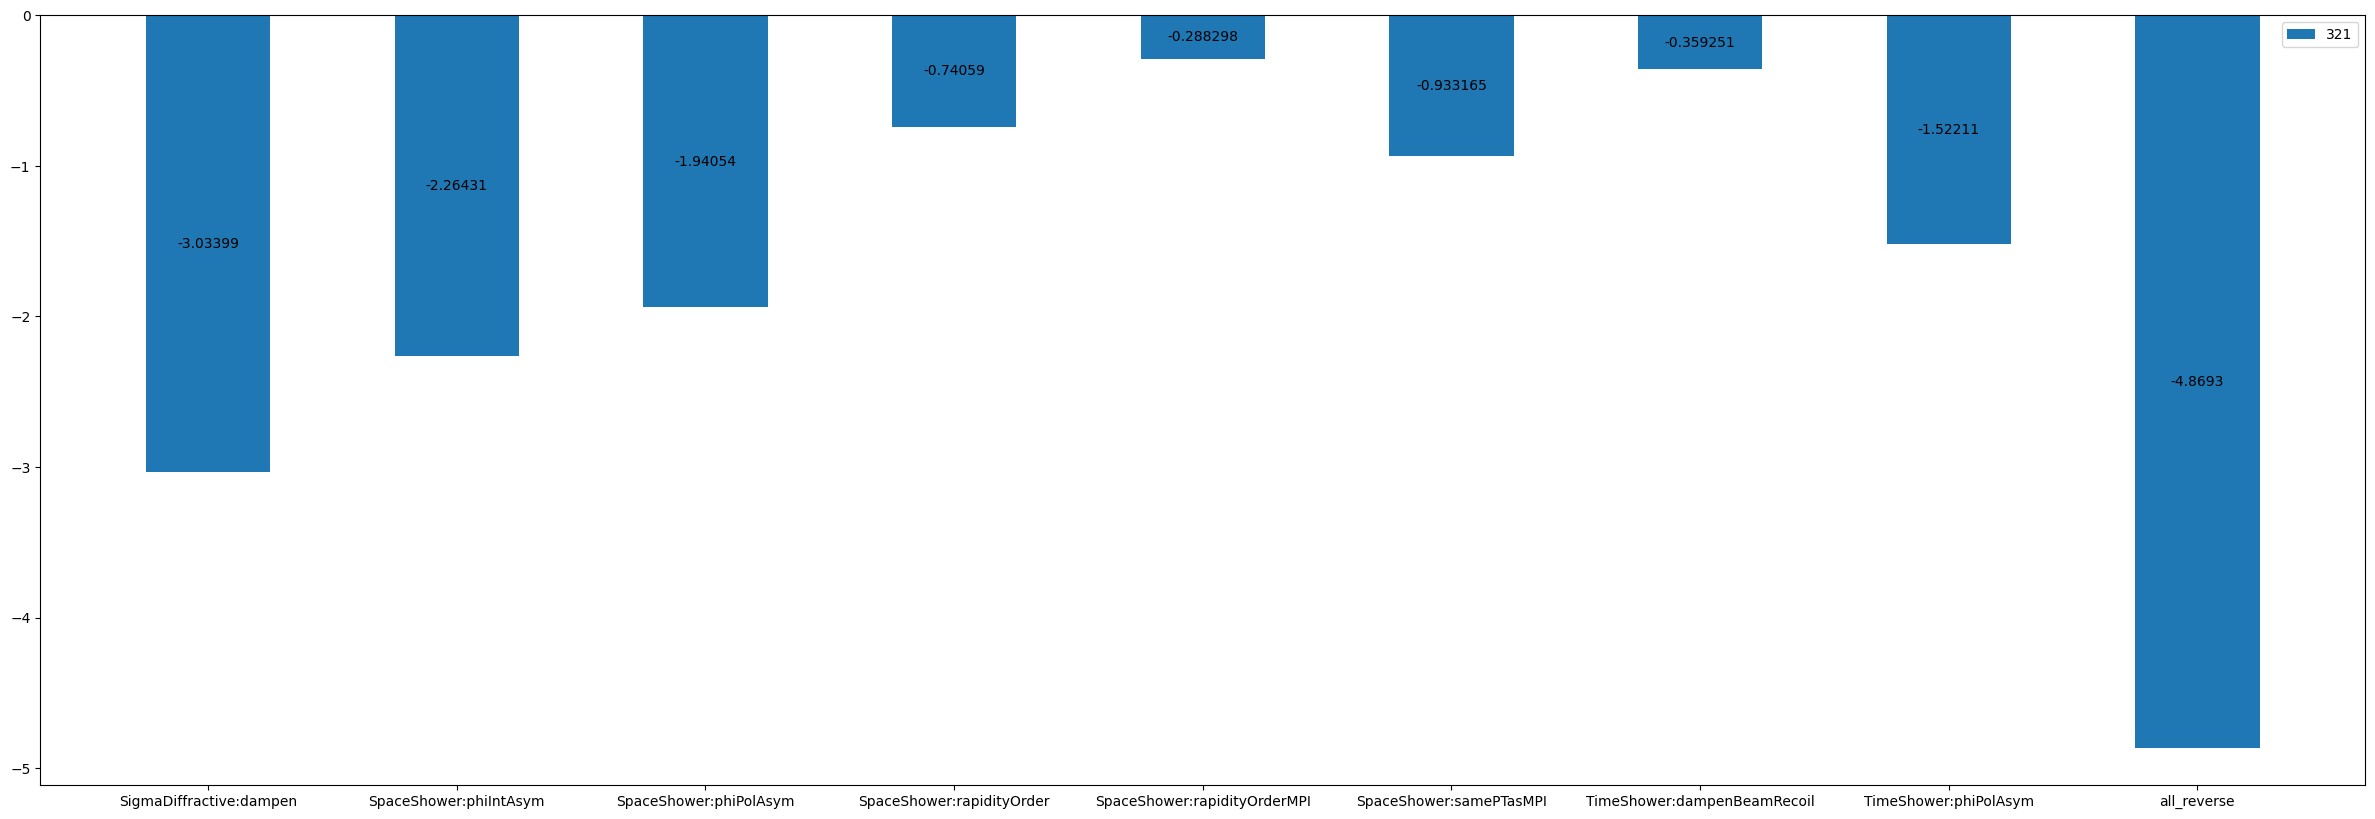

In [23]:
width = 0.5

plt.figure(figsize=(30, 10))

bottom = np.zeros(len(metrics_without_qcd) - 1)

res = np.array(list(metrics_without_qcd.values())).sum(axis=1)

res = res[1:] - res[0]

p = plt.bar(list(metrics_without_qcd.keys())[1:], res, width, label=id, bottom=bottom)

plt.bar_label(p, label_type='center')

plt.legend()

plt.show()

The best results are when all switches have default values

># PDF check

In [79]:
pdfs = ['2', '13']

In [80]:
for pdf in pdfs:

    gen_data(exp_name=f'pdf_{pdf}',
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=1,
         additional_instructions={'PDF:pSet': pdf},
         n_events=N_events)

100%|██████████| 10000000/10000000 [18:37<00:00, 8947.16it/s] 


In [81]:
metrics = {}

for pdf in pdfs:

    metrics[pdf] = []

    sigma_file = open(f'gen_data/pdf_{pdf}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    for id in ids:

        data = pd.read_csv(f'gen_data/pdf_{pdf}/{id}.csv')
        ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

        xsect, err = xsect_calc(data, sig_total)

        res = calc_metric(chi_square, xsect, err, ref)

        metrics[pdf].append(np.mean(res))

/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_2758/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_2758/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)


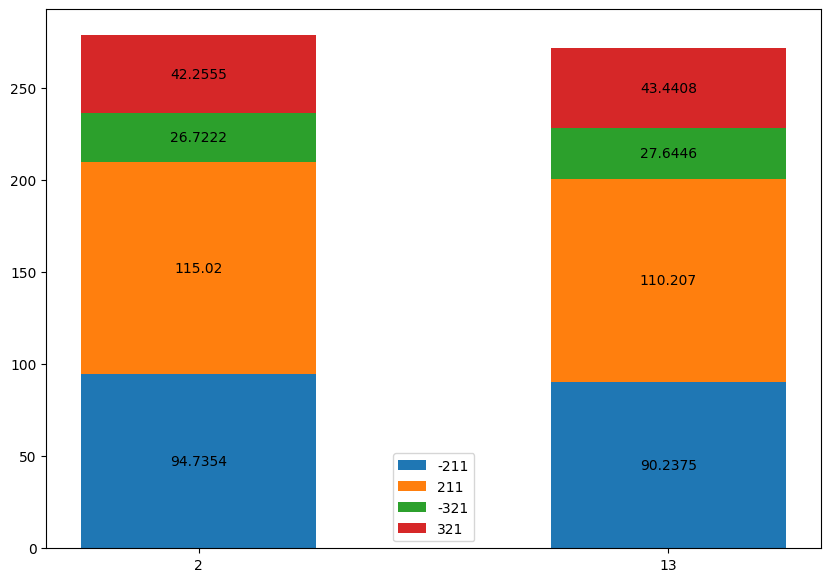

In [82]:
width = 0.5

plt.figure(figsize=(10, 7))

bottom = np.zeros(len(pdfs))

for num, id in enumerate(ids):

    res = np.array(list(metrics.values()))[:, num]

    p = plt.bar(metrics.keys(), res, width, label=id, bottom=bottom)
    bottom += res

    plt.bar_label(p, label_type='center')

plt.legend()

plt.show()

The default value of `PDF:pSet` shows better results